# PageRank in [Apache Spark](http://spark.apache.org)

This is one of the basic examples how Apache Spark works and how it looks like.

Make sure to read about [Transformations](http://spark.apache.org/docs/latest/programming-guide.html#transformations) and especially map, flatMap, join, ...

Read more about the RDD's [Python API](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD).

When using the "Apache Spark" themes kernels in SageMathCloud,
the object "`sc`" for the "Spark Context" is already pre-initialized.

In [1]:
sc

The data for your simplified link graph.

In [2]:
link_data = {
    0: [1, 11],
    1: [2, 6],
    2: [1, 0],
    3: [1, 0],
    4: [1],
    5: [0, 1],
    6: [0, 7],
    7: [0, 1, 2, 3, 9],
    8: [0, 5, 9],
    9: [7, 11],
    10: [4, 7],
    11: [0, 10]
}

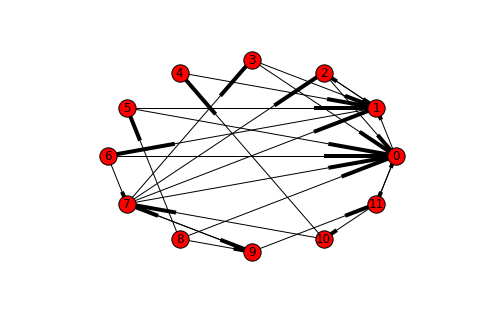

In [3]:
import networkx as nx
link_graph = nx.DiGraph(link_data)
labels = dict((n, str(n)) for n in link_graph.nodes())
nx.draw_circular(link_graph, labels = labels)

The initial rank-data is the value 1. for each node.

In [4]:
ranks = sc.parallelize(link_data.keys()).map(lambda x : (x, 1.))

This initializes the edges of the graph data as `links`, which are modeled in Spark as key-value-tuples.

In [5]:
links = sc.parallelize(link_data.items()).cache()

This is a demonstration of what does happen, when the rank-key-value tuples are joined with the links-key-value tuples.
Take a close look, it's a list of tuples in tuples with lists inside of them!

In [6]:
sorted(links.join(ranks).collect())

[(0, ([1, 11], 1.0)),
 (1, ([2, 6], 1.0)),
 (2, ([1, 0], 1.0)),
 (3, ([1, 0], 1.0)),
 (4, ([1], 1.0)),
 (5, ([0, 1], 1.0)),
 (6, ([0, 7], 1.0)),
 (7, ([0, 1, 2, 3, 9], 1.0)),
 (8, ([0, 5, 9], 1.0)),
 (9, ([7, 11], 1.0)),
 (10, ([4, 7], 1.0)),
 (11, ([0, 10], 1.0))]

In [7]:
def computeContribs(node_urls_rank):
    """
    This function takes elements from the joined dataset above and
    computes the contribution to each outgoing link based on the
    current rank.
    """
    _, (urls, rank) = node_urls_rank
    nb_urls = len(urls)
    for url in urls:
        yield url, rank / nb_urls

Here is a debug printout to outline what the first operation in the code below is doing:

In [8]:
c = links.join(ranks).flatMap(computeContribs)
print(c.toDebugString().decode("utf8"))

(1) PythonRDD[17] at RDD at PythonRDD.scala:43 []
 |  MapPartitionsRDD[16] at mapPartitions at PythonRDD.scala:374 []
 |  ShuffledRDD[15] at partitionBy at NativeMethodAccessorImpl.java:-2 []
 +-(2) PairwiseRDD[14] at _run_module_as_main at /projects/anaconda3/lib/python3.5/runpy.py:170 []
    |  PythonRDD[13] at _run_module_as_main at /projects/anaconda3/lib/python3.5/runpy.py:170 []
    |  UnionRDD[12] at union at NativeMethodAccessorImpl.java:-2 []
    |  PythonRDD[10] at RDD at PythonRDD.scala:43 []
    |  ParallelCollectionRDD[1] at parallelize at PythonRDD.scala:423 []
    |      CachedPartitions: 1; MemorySize: 221.0 B; ExternalBlockStoreSize: 0.0 B; DiskSize: 0.0 B
    |  PythonRDD[11] at RDD at PythonRDD.scala:43 []
    |  ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:423 []


## Executing the PageRank Algorithm

This takes a while to execute. Do

    tail -f ~/.smc/jupyter/jupyter-notebook.*
    
in a Terminal to see what's going on behind the scenes!

In [9]:
from operator import add

for iteration in range(10):
    # compute contributions of each node where it links to
    contribs = links.join(ranks).flatMap(computeContribs)

    # use a full outer join to make sure, that not well connected nodes aren't dropped
    contribs = links.fullOuterJoin(contribs).mapValues(lambda x : x[1] or 0.0)

    # Sum up all contributions per link
    ranks = contribs.reduceByKey(add)

    # Re-calculate URL ranks
    ranks = ranks.mapValues(lambda rank: rank * 0.85 + 0.15)
    
# Collects all URL ranks
for (link, rank) in sorted(ranks.collect()):
    print("%s has rank: %s." % (link, rank / len(link_data)))

0 has rank: 0.18868310146544207.
1 has rank: 0.209039646026545.
2 has rank: 0.11721980982628066.
3 has rank: 0.028463192013959495.
4 has rank: 0.037044621083774015.
5 has rank: 0.016041666666666666.
6 has rank: 0.10125661781232116.
7 has rank: 0.09357898007794324.
8 has rank: 0.012499999999999999.
9 has rank: 0.03200485868062616.
10 has rank: 0.05761473312981078.
11 has rank: 0.10655277321663052.


## Comparison with NetworkX

In [10]:
import networkx as nx
g = nx.DiGraph(link_data)
nx.pagerank(g)

{0: 0.18892560439419176,
 1: 0.20889512487491022,
 2: 0.11720230098777328,
 3: 0.028421454329497692,
 4: 0.03702665223140903,
 5: 0.01604166666666667,
 6: 0.10128084665827558,
 7: 0.09365504547040693,
 8: 0.0125,
 9: 0.03196312099616436,
 10: 0.05771090525336493,
 11: 0.10637727813733949}

## Task

Now go back to the directed graph in the beginning and make up your mind if those numbers make sense or not.
Why is the weight of node 1 higher than the weight of node 2?